In [1]:
import time
start_time=time.time()

In [2]:
from pathlib import Path

from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy import interpolate
import json

import strucfunc
from strucfunc import sosflog
import bfunc

Input path: velocity fields folder

In [3]:
text_file_0 = open("path-data.txt", "r")
path_data = text_file_0.read()

In [4]:
datapath_data = Path(path_data).expanduser()

#Output path: results folder location

In [5]:
#text_file_1 = open("path-results.txt", "r")
#path_res = text_file_1.read()

In [6]:
#datapath_res= Path(path_res).expanduser()

File names

In [7]:
name = 'Hanel-EON-S'

In [8]:
data = json.load(open(str(datapath_data) + '/' + name + "-m.json"))
#sb = np.array(data["sb"])
vv = np.array(data["vv"])
#ss = np.array(data["ss"])

In [9]:
vv[vv== 'nan'] = vv.mean()

<ipython-input-9-61e9d6bb38fe>:1: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  vv[vv== 'nan'] = vv.mean()


In [10]:
## Replace spurious values in the arrays
#m = ~np.isfinite(sb*vv) | (sb < 0.0)

#sb[m] = 0.0
#vv[m] = np.nanmean(vv)
#ss[m] = 0.0
#sb /= sb.max()
#good = (~m) & (sb > 0.001)

In [11]:
m = ~np.isfinite(vv) 
vv[m] = np.nanmean(vv)
good = (~m) 

In [12]:
box_size = np.sqrt(vv.shape[0] * vv.shape[1]) * data['pix'] * data['pc']

In [13]:
rslt = strucfunc.strucfunc_numba_parallel(vv, dlogr=0.05)

C:\Users\ZAINTEL2\Documents\Aeon\PhD\python\git-hub\structure-functions\strucfunc.py:83: RuntimeWarning: invalid value encountered in true_divide
  'Unweighted B(r)': sf/nsf,
C:\Users\ZAINTEL2\Documents\Aeon\PhD\python\git-hub\structure-functions\strucfunc.py:84: RuntimeWarning: invalid value encountered in true_divide
  'Weighted B(r)': wsf/weight}


In [14]:
rslt

{'log10 r': array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  , 1.05,
        1.1 , 1.15, 1.2 , 1.25, 1.3 , 1.35, 1.4 , 1.45]),
 'Sum dv^2': array([  7487.85647583,      0.        ,      0.        ,  15680.73179548,
             0.        ,      0.        ,  40635.02298909,      0.        ,
             0.        ,  23996.07930154,  32336.98947476,  32273.25983764,
         54884.1817717 ,  71177.35250569,  60388.63439806,  82791.10893396,
        137671.08408919, 110385.80862084, 154619.2936375 , 195592.90004859,
        274141.12905066, 249225.66762599, 292467.84314396, 346871.03503971,
        310633.81858428, 254910.83759986, 149252.5950701 ,  63526.63892926,
         13839.24670087,   1416.27640757]),
 'Sum weights': array([  506.,     0.,     0.,   966.,     0.,     0.,  2328.,     0.,
            0.,  1342.,  1756.,  1676.,  2906.,  3526.,  3088.,  4044.,
         6568.,  5124.,  7056.,  871

In [15]:
rslt["Unweighted mean velocity"] = np.mean(vv[good])
rslt["Unweighted sigma^2"] = np.var(vv[good])
#v0w = rslt["Weighted mean velocity"] = np.average(vv, weights=sb)
#rslt["Weighted sigma^2"] = np.average((vv - v0w)**2, weights=sb)

In [16]:
b2 = rslt['Unweighted B(r)']
#b2w = rslt['Weighted B(r)']
e_b2 = b2  *.1
#e_b2w = b2w  *.1

s = 10**rslt['log10 r'] * data['pix'] * data['pc']
e_s = s  *.1
sig2 = rslt['Unweighted sigma^2']
#sig2w = rslt['Weighted sigma^2']

sig = sig2**0.5

In [17]:
r0 = np.interp(sig2, b2[1:10], s[1:10])
r0

0.3361320885059206

In [18]:
r1 = np.interp(sig, b2[1:10], s[1:10])
r1

nan

In [19]:
r2 = np.interp(2*sig2, b2, s, period = 360)
r2

C:\Users\ZAINTEL2\anaconda3\lib\site-packages\numpy\lib\function_base.py:1405: RuntimeWarning: invalid value encountered in remainder
  xp = xp % period


nan

(22.401574257571088, 0.3361320885059206, 0.5)

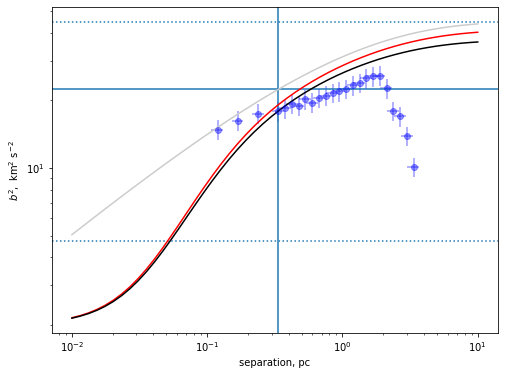

In [20]:
m = 0.5
s0 = data['s0']
noise = 2

fig, ax = plt.subplots(figsize=(8, 6))
rgrid = np.logspace(-2, 1)
ax.errorbar(s, b2, yerr=e_b2, xerr=e_s, fmt='o', alpha=0.4,color="blue")
#ax.errorbar(s, b2w, yerr=e_b2w, xerr=e_s, fmt='x', alpha=0.4,color="green")

ax.axhline(sig2, ls='-')
ax.axvline(r0, ls='-')

ax.axhline(2*sig2, ls=':')
ax.axvline(r2, ls=':')

ax.axhline(sig, ls=':')
ax.axvline(r1, ls=':')

ax.plot(rgrid, bfunc.bfunc00s(rgrid, r0, sig2, m), color="0.8")
ax.plot(rgrid, bfunc.bfunc03s(rgrid, r0, sig2, m, s0, noise), color="red")
ax.plot(rgrid, bfunc.bfunc04s(rgrid, r0, sig2, m, s0, noise, box_size), color="black")


ax.set(xscale='log', yscale='log', 
       xlabel='separation, pc',
       ylabel=r'$b^2,\ \mathrm{km^2\ s^{-2}}$'
      )
None

sig2, r0, m

In [21]:
results = {
    'sig2' : sig2,
        'r0' : r0,
        'r1' : r1,
        'r2' : r2,
          } 

In [22]:
data_export = {   
        's' : s,
        'b2' : b2,
        'pc' : data['pc'],
        'pix' : data['pix'],
        'box_size': box_size,
         'results':results,
         'SF' : rslt,
         'VF' : data,
}

In [23]:
class MyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return super(MyEncoder, self).default(obj)

In [24]:
jsonfilename ="sf-" + name +".json"
with open(jsonfilename, "w") as f:
    json.dump(data_export, fp=f, indent=3, cls=MyEncoder)

In [25]:
print("--- %s seconds ---" % (time.time()-start_time))

--- 8.909914493560791 seconds ---


In [26]:
!jupyter nbconvert --to script --no-prompt sf-Hanel-EON-S.ipynb

[NbConvertApp] Converting notebook sf-Hanel-EON-S.ipynb to script
[NbConvertApp] Writing 3556 bytes to sf-Hanel-EON-S.py
